# Dicas de avaliacao de modelos
foco em problemas de classificacao

### importando bibliotecas

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")


pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_columns', 50)

### carregando base de dados

Kobe Bryant Shot Selection - Dados historicos sobre os arremessos de Kobe

In [2]:
df = pd.read_csv('./input/data.csv')
sample_submission = pd.read_csv('./input/sample_submission.csv')

In [3]:
df

,action_type,combined_shot_type,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period,playoffs,season,seconds_remaining,shot_distance,shot_made_flag,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,team_id,team_name,game_date,matchup,opponent,shot_id
0,Jump Shot,Jump Shot,10,20000012,33.97,167,72,-118.10,10,1,0,2000-01,27,18,nan,2PT Field Goal,Right Side(R),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,1
1,Jump Shot,Jump Shot,12,20000012,34.04,-157,0,-118.43,10,1,0,2000-01,22,15,0.00,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,2
2,Jump Shot,Jump Shot,35,20000012,33.91,-101,135,-118.37,7,1,0,2000-01,45,16,1.00,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,3
3,Jump Shot,Jump Shot,43,20000012,33.87,138,175,-118.13,6,1,0,2000-01,52,22,0.00,2PT Field Goal,Right Side Center(RC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,4
4,Driving Dunk Shot,Dunk,155,20000012,34.04,0,0,-118.27,6,2,0,2000-01,19,0,1.00,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30692,Jump Shot,Jump Shot,397,49900088,34.00,1,48,-118.27,6,4,1,1999-00,5,4,0.00,2PT Field Goal,Center(C),In The Paint (Non-RA),Less Than 8 ft.,1610612747,Los Angeles Lakers,2000-06-19,LAL vs. IND,IND,30693
30693,Tip Shot,Tip Shot,398,49900088,34.04,0,0,-118.27,6,4,1,1999-00,5,0,nan,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612747,Los Angeles Lakers,2000-06-19,LAL vs. IND,IND,30694
30694,Running Jump Shot,Jump Shot,426,49900088,33.88,-134,166,-118.40,3,4,1,1999-00,28,21,1.00,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-06-19,LAL vs. IND,IND,30695
30695,Jump Shot,Jump Shot,448,49900088,33.78,31,267,-118.24,2,4,1,1999-00,10,26,0.00,3PT Field Goal,Center(C),Above the Break 3,24+ ft.,1610612747,Los Angeles Lakers,2000-06-19,LAL vs. IND,IND,30696


### retirando amostras sem flag

In [4]:
df_EDA = df[~df.shot_id.isin(sample_submission.shot_id)]

### analise de missings

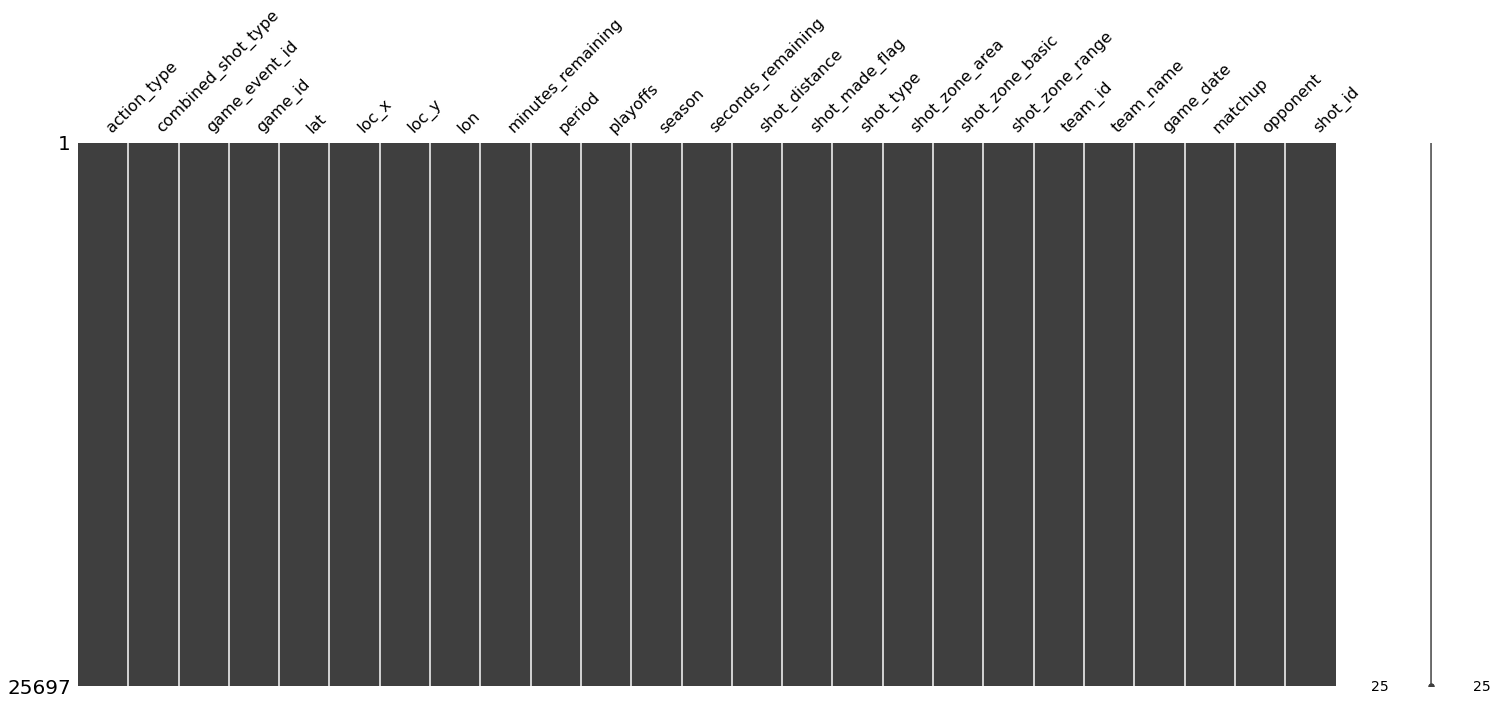

In [5]:
import missingno as msno

msno.matrix(df_EDA);

### ajustando e criando algumas variaveis

In [6]:
#season e game_date sao campos de datas, vamos ajustar
df_EDA.season.unique()

#o formato ta bem zuado, vou dropar essa info e trabalhar com o game_date
df_EDA.drop('season', axis=1,inplace=True)
df_EDA.game_date.unique()
df_EDA['game_date'] = pd.to_datetime(df_EDA.game_date, format='%Y-%m-%d')

#ou criar a feature year e month pra avaliar se influencia no jogo dele
df_EDA['year'] = df_EDA.game_date.apply(lambda x: x.strftime("%Y")).astype(int)
df_EDA['month'] = df_EDA.game_date.apply(lambda x: x.strftime("%m")).astype(int)

#ajustar o campo de segundos
df_EDA['seconds_remaining']=60 * df_EDA['minutes_remaining'] + df_EDA['seconds_remaining']
df_EDA['last_5_sec_in_period'] = df_EDA['seconds_remaining'] < 5

### descartando variaveis que nao fazem sentido

In [7]:
df_EDA=df_EDA.drop(['game_event_id','game_id','team_id','shot_id','game_date'],axis=1)

### separando tipos de variaveis

In [8]:
target = df_EDA[["shot_made_flag"]]

importante para analisarmos de forma diferente

In [9]:
dfn = df_EDA.select_dtypes(exclude=['object','bool'])
dfn=dfn.drop("shot_made_flag",axis=1)
dfn.columns

Index(['lat', 'loc_x', 'loc_y', 'lon', 'minutes_remaining', 'period',
       'playoffs', 'seconds_remaining', 'shot_distance', 'year', 'month'],
      dtype='object')

In [10]:
dfs = df_EDA.select_dtypes(include=['object','bool'])
dfs.columns

Index(['action_type', 'combined_shot_type', 'shot_type', 'shot_zone_area',
       'shot_zone_basic', 'shot_zone_range', 'team_name', 'matchup',
       'opponent', 'last_5_sec_in_period'],
      dtype='object')

## numericas

### analisando correlacao
Precisamos retirar correlacao para nao atrapalhar o entendimento do modelo

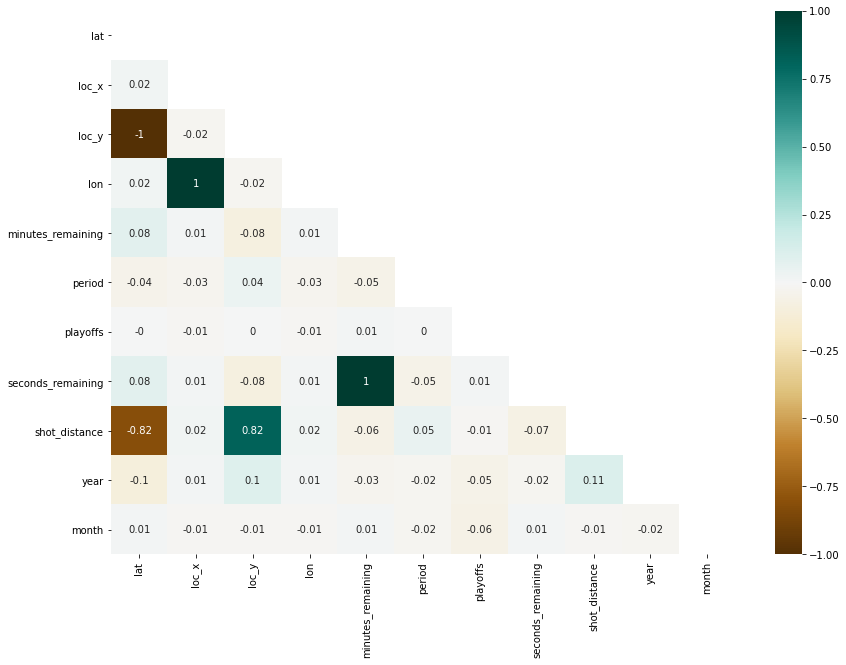

In [11]:
matrix = np.triu(dfn.corr())

fig, axs = plt.subplots(figsize=(14,10))

sns.heatmap(np.round(dfn.corr(),2), cmap ='BrBG' ,annot=True, mask=matrix);

#### selecionando apenas as variaveis com baixa correlacao

In [12]:
corr = dfn.corr()

columns = np.full((corr.shape[0],), True, dtype=bool)
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i,j] >= 0.9:
            if columns[j]:
                columns[j] = False
selected_columns = dfn.columns[columns]

In [13]:
dfn.shape

(25697, 11)

In [14]:
dfn_corr = dfn[selected_columns]
dfn_corr.shape

(25697, 9)

### analisando outliers

necessario decidir se drop ou nao os outliers

In [15]:
dfn.describe()

,lat,loc_x,loc_y,lon,minutes_remaining,period,playoffs,seconds_remaining,shot_distance,year,month
count,"25,697.00","25,697.00","25,697.00","25,697.00","25,697.00","25,697.00","25,697.00","25,697.00","25,697.00","25,697.00","25,697.00"
mean,33.95,7.15,91.26,-118.26,4.89,2.52,0.15,321.52,13.46,"2,006.12",5.57
std,0.09,110.07,88.15,0.11,3.45,1.15,0.35,208.31,9.39,4.83,4.15
min,33.25,-250.00,-44.00,-118.52,0.00,1.00,0.00,0.00,0.00,"1,996.00",1.00
25%,33.88,-67.00,4.00,-118.34,2.00,1.00,0.00,141.00,5.00,"2,002.00",2.00
50%,33.97,0.00,74.00,-118.27,5.00,3.00,0.00,304.00,15.00,"2,006.00",4.00
75%,34.04,94.00,160.00,-118.18,8.00,3.00,0.00,499.00,21.00,"2,010.00",11.00
max,34.09,248.00,791.00,-118.02,11.00,7.00,1.00,714.00,79.00,"2,016.00",12.00


In [16]:
def detect_outliers(series, whis=1.5):
    q75, q25 = np.percentile(series, [75 ,25])
    iqr = q75 - q25
    return ~((series - series.median()).abs() <= (whis * iqr))

A=[]
for varx in dfn.columns:
    A.append(pd.DataFrame(detect_outliers(dfn[varx]).value_counts(normalize=True)))
a = pd.concat(A,axis=1).fillna(0)
a

,lat,loc_x,loc_y,lon,minutes_remaining,period,playoffs,seconds_remaining,shot_distance,year,month
False,0.99,1.00,0.99,1.00,1.00,1.00,0.85,1.00,1.00,1.00,1.00
True,0.01,0.00,0.01,0.00,0.00,0.00,0.15,0.00,0.00,0.00,0.00


#### muito cuidado, se vc dropar as linhas, vai acabar desalinhando o frame, assim nao vai conseguir concatenar com a dfs. Lembrar de usar um merge com o indice, e nao dar reset_index()

aparentemente nenhuma variavel apresenta mtos outliers
(boxplots tb sao legais aqui)

### feature transform

Polynomial Features

In [17]:
from sklearn.preprocessing import PolynomialFeatures

pf = PolynomialFeatures(degree=2, interaction_only=False,  
                        include_bias=False)


In [18]:
res = pf.fit_transform(dfn_corr)
dfn_poly = pd.DataFrame(res)

In [19]:
dfn_poly

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,...,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53
0,34.04,-157.00,0.00,10.00,1.00,0.00,15.00,"2,000.00",10.00,"1,159.01","-5,344.96",0.00,340.44,34.04,0.00,510.66,"68,088.60",340.44,"24,649.00",-0.00,"-1,570.00",-157.00,-0.00,"-2,355.00","-314,000.00",...,0.00,0.00,0.00,0.00,100.00,10.00,0.00,150.00,"20,000.00",100.00,1.00,0.00,15.00,"2,000.00",10.00,0.00,0.00,0.00,0.00,225.00,"30,000.00",150.00,"4,000,000.00","20,000.00",100.00
1,33.91,-101.00,135.00,7.00,1.00,0.00,16.00,"2,000.00",10.00,"1,149.84","-3,424.84","4,577.76",237.37,33.91,0.00,542.55,"67,818.60",339.09,"10,201.00","-13,635.00",-707.00,-101.00,-0.00,"-1,616.00","-202,000.00",...,0.00,"2,160.00","270,000.00","1,350.00",49.00,7.00,0.00,112.00,"14,000.00",70.00,1.00,0.00,16.00,"2,000.00",10.00,0.00,0.00,0.00,0.00,256.00,"32,000.00",160.00,"4,000,000.00","20,000.00",100.00
2,33.87,138.00,175.00,6.00,1.00,0.00,22.00,"2,000.00",10.00,"1,147.13","4,673.96","5,927.13",203.22,33.87,0.00,745.12,"67,738.60",338.69,"19,044.00","24,150.00",828.00,138.00,0.00,"3,036.00","276,000.00",...,0.00,"3,850.00","350,000.00","1,750.00",36.00,6.00,0.00,132.00,"12,000.00",60.00,1.00,0.00,22.00,"2,000.00",10.00,0.00,0.00,0.00,0.00,484.00,"44,000.00",220.00,"4,000,000.00","20,000.00",100.00
3,34.04,0.00,0.00,6.00,2.00,0.00,0.00,"2,000.00",10.00,"1,159.01",0.00,0.00,204.27,68.09,0.00,0.00,"68,088.60",340.44,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,36.00,12.00,0.00,0.00,"12,000.00",60.00,4.00,0.00,0.00,"4,000.00",20.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,"4,000,000.00","20,000.00",100.00
4,34.06,-145.00,-11.00,9.00,3.00,0.00,14.00,"2,000.00",10.00,"1,159.76","-4,938.02",-374.61,306.50,102.17,0.00,476.77,"68,110.60",340.55,"21,025.00","1,595.00","-1,305.00",-435.00,-0.00,"-2,030.00","-290,000.00",...,-0.00,-154.00,"-22,000.00",-110.00,81.00,27.00,0.00,126.00,"18,000.00",90.00,9.00,0.00,42.00,"6,000.00",30.00,0.00,0.00,0.00,0.00,196.00,"28,000.00",140.00,"4,000,000.00","20,000.00",100.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25692,34.04,0.00,0.00,7.00,4.00,1.00,0.00,"2,000.00",6.00,"1,159.01",0.00,0.00,238.31,136.18,34.04,0.00,"68,088.60",204.27,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,49.00,28.00,7.00,0.00,"14,000.00",42.00,16.00,4.00,0.00,"8,000.00",24.00,1.00,0.00,"2,000.00",6.00,0.00,0.00,0.00,"4,000,000.00","12,000.00",36.00
25693,34.00,1.00,48.00,6.00,4.00,1.00,4.00,"2,000.00",6.00,"1,155.75",34.00,"1,631.82",203.98,135.99,34.00,135.99,"67,992.60",203.98,1.00,48.00,6.00,4.00,1.00,4.00,"2,000.00",...,48.00,192.00,"96,000.00",288.00,36.00,24.00,6.00,24.00,"12,000.00",36.00,16.00,4.00,16.00,"8,000.00",24.00,1.00,4.00,"2,000.00",6.00,16.00,"8,000.00",24.00,"4,000,000.00","12,000.00",36.00
25694,33.88,-134.00,166.00,3.00,4.00,1.00,21.00,"2,000.00",6.00,"1,147.74","-4,539.69","5,623.80",101.63,135.51,33.88,711.44,"67,756.60",203.27,"17,956.00","-22,244.00",-402.00,-536.00,-134.00,"-2,814.00","-268,000.00",...,166.00,"3,486.00","332,000.00",996.00,9.00,12.00,3.00,63.00,"6,000.00",18.00,16.00,4.00,84.00,"8,000.00",24.00,1.00,21.00,"2,000.00",6.00,441.00,"42,000.00",126.00,"4,000,000.00","12,000.00",36.00
25695,33.78,31.00,267.00,2.00,4.00,1.00,26.00,"2,000.00",6.00,"1,140.91","1,047.10","9,018.54",67.55,135.11,33.78,878.21,"67,554.60",202.66,961.00,"8,277.00",62.00,124.00,31.00,806.00,"62,000.00",...,267.00,"6,942.00","534,000.00","1,602.00",4.00,8.00,2.00,52.00,"4,000.00",12.00,16.00,4.00,104.00,"8,000.00",24.00,1.00,26.00,"2,000.00",6.00,676.00,"52,000.00",156.00,"4,000,000.00","12,000.00",36.00


### Log transformation

In [20]:
dfn_corr

,lat,loc_x,loc_y,minutes_remaining,period,playoffs,shot_distance,year,month
1,34.04,-157,0,10,1,0,15,2000,10
2,33.91,-101,135,7,1,0,16,2000,10
3,33.87,138,175,6,1,0,22,2000,10
4,34.04,0,0,6,2,0,0,2000,10
5,34.06,-145,-11,9,3,0,14,2000,10
...,...,...,...,...,...,...,...,...,...
30691,34.04,0,0,7,4,1,0,2000,6
30692,34.00,1,48,6,4,1,4,2000,6
30694,33.88,-134,166,3,4,1,21,2000,6
30695,33.78,31,267,2,4,1,26,2000,6


In [21]:
dfn_log = dfn_corr.copy()

#### var ["shot_distance"]

Text(0.5, 1.0, 'Sem log transform')

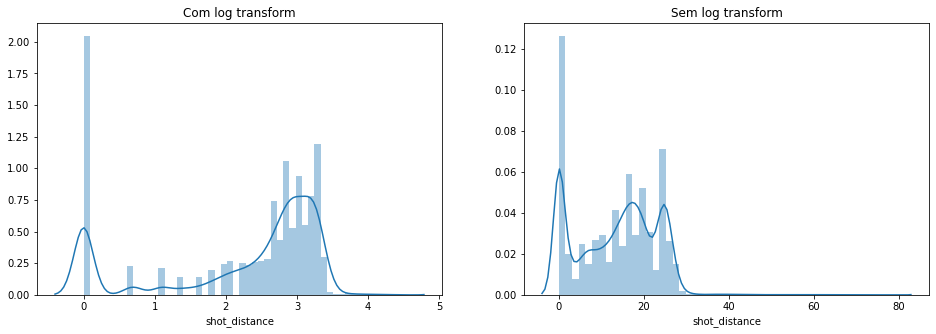

In [22]:
dfn_log['shot_distance'] = np.log((1+ dfn_log['shot_distance']))

fig, axs = plt.subplots(nrows=1,ncols=2,figsize=(16,5))

sns.distplot(dfn_log['shot_distance'],ax=axs[0]).set_title('Com log transform')
sns.distplot(dfn_corr['shot_distance'],ax=axs[1]).set_title('Sem log transform')

#### var ["minutes_remaining"]

Text(0.5, 1.0, 'Sem log transform')

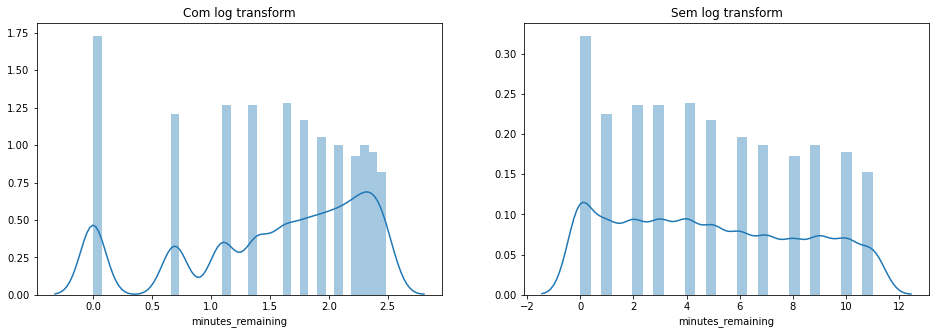

In [23]:
dfn_log['minutes_remaining'] = np.log((1+ dfn_log['minutes_remaining']))

fig, axs = plt.subplots(nrows=1,ncols=2,figsize=(16,5))

sns.distplot(dfn_log['minutes_remaining'],ax=axs[0]).set_title('Com log transform')
sns.distplot(dfn_corr['minutes_remaining'],ax=axs[1]).set_title('Sem log transform')

## categoricas

### analisando correlacao

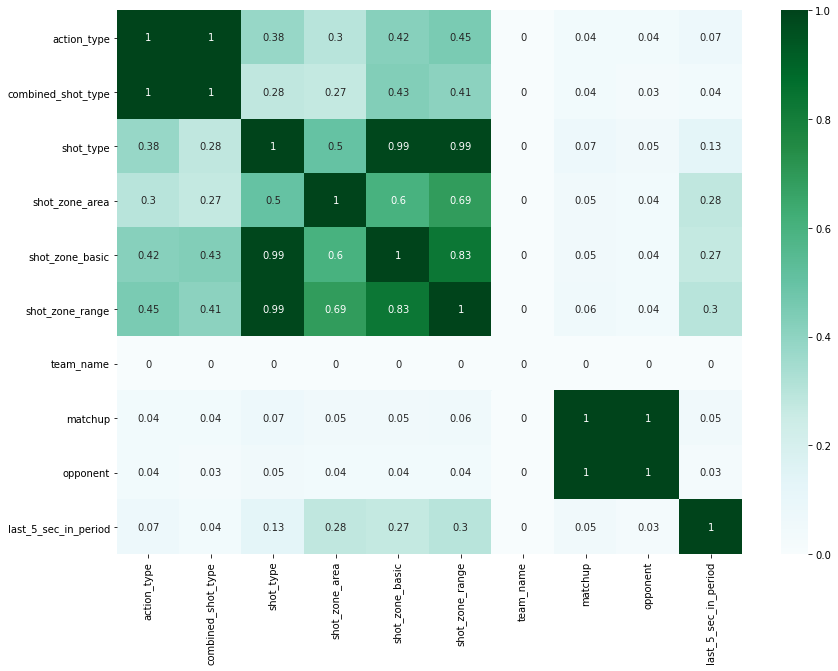

In [24]:
from dython.nominal import compute_associations

mtz_v=compute_associations(dfs, theil_u=False)

fig, axs = plt.subplots(figsize=(14,10))
sns.heatmap(np.round(mtz_v,2), cmap ='BuGn' ,annot=True);

#### selecionando apenas as variaveis com baixa correlacao

In [25]:
corr = np.round(mtz_v,2)

columns = np.full((corr.shape[0],), True, dtype=bool)
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i,j] >= 0.9:
            if columns[j]:
                columns[j] = False
selected_columns = dfs.columns[columns]

In [26]:
dfs.shape

(25697, 10)

In [27]:
dfs = dfs[selected_columns]
dfs.shape

(25697, 6)

### Avaliando a multiplicidade das classes de cada variavel categorica.
A ideia eh reduzir a quantidade de var dummings (agrupando) -- > problema de alta dimensionalidade

In [28]:
W=[]

for i in dfs.columns:

    s=pd.merge(pd.DataFrame(dfs[i].value_counts()),pd.DataFrame(dfs[i].value_counts(normalize=True)),how="left",left_index=True, right_index=True)
    s=s.reset_index()
    s.columns=["var_name",'#obs','percent']
    s["cum"] =np.flipud(np.flipud(s.percent).cumsum())
    
    corte = 0.1
    # qtd_strong%
    q_strong = s[s.cum > corte].shape[0]
    l_strong = list(s[s.cum > corte].var_name)

    # qtd_weak%
    q_weak = s.shape[0] - q_strong
    l_weak = list(s[s.cum<= corte].var_name)
    
    # Total
    q_tot = s.shape[0]

    w = (i, q_tot, q_strong, q_weak, l_strong, l_weak)
    W.append(w)

    
S=pd.DataFrame(W, columns = ["var_name","qtd_classes_tot", "qtd_classe_strong", "qtd_classe_weak", "list_strong", "list_weak" ]).sort_values(by=["qtd_classes_tot"],ascending=False).reset_index(drop=True)

In [29]:
print("Total de variaveis a serem criadas por dumming: "+str(S.qtd_classes_tot.sum()))
print("90% das variaveis a serem criadas por dumming: "+str(S.qtd_classe_strong.sum()))

Total de variaveis a serem criadas por dumming: 140
90% das variaveis a serem criadas por dumming: 70


In [30]:
S

,var_name,qtd_classes_tot,qtd_classe_strong,qtd_classe_weak,list_strong,list_weak
0,matchup,74,52,22,"[LAL @ SAS, LAL vs. SAS, LAL @ PHX, LAL @ SAC,...","[LAL vs. NOH, LAL @ NOH, LAL @ NJN, LAL vs. WA..."
1,action_type,55,9,46,"[Jump Shot, Layup Shot, Driving Layup Shot, Tu...","[Reverse Layup Shot, Jump Bank Shot, Driving D..."
2,shot_zone_area,6,5,1,"[Center(C), Right Side Center(RC), Right Side(...",[Back Court(BC)]
3,shot_type,2,2,0,"[2PT Field Goal, 3PT Field Goal]",[]
4,last_5_sec_in_period,2,1,1,[False],[True]
5,team_name,1,1,0,[Los Angeles Lakers],[]


#### vale a pena dar uma agrupada nas variaveis matchup e action_type

In [31]:
dfs_other = dfs.copy()

In [32]:
lista = ["matchup", "action_type"]

for i in lista:
    
    list_weak = list(S[S.var_name == i].list_weak)
    dfs_other[i] = dfs_other[i].replace(list_weak,"other")  

#### conferindo

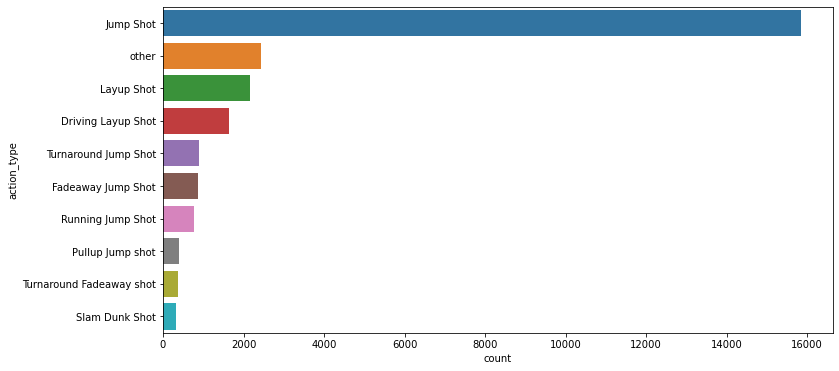

In [33]:
fig= plt.subplots(figsize=(12,6))
sns.countplot(y = "action_type",  data= dfs_other, order=dfs_other.action_type.value_counts().index) ;

#### Transformar em Dumming

In [34]:
vars_cat=pd.get_dummies(dfs)
vars_cat_other=pd.get_dummies(dfs_other)

### recapitulando

In [35]:
print("base original:" + str(dfn.shape[1] +dfs.shape[1]))
print("")
print("base features numericas original: "+str(dfn_corr.shape[1]))
print("base features numericas sem correlacao com log: "+str(dfn_log.shape[1]))
print("base features numericas sem correlacao com poly: "+str(dfn_poly.shape[1]))

print("")
print("base features categoricas original: "+str(dfs.shape[1]))
print("base features categoricas dumming: "+str(vars_cat.shape[1]))
print("base features categoricas dumming other: "+str(vars_cat_other.shape[1]))
print("")


base original:17

base features numericas original: 9
base features numericas sem correlacao com log: 9
base features numericas sem correlacao com poly: 54

base features categoricas original: 6
base features categoricas dumming: 139
base features categoricas dumming other: 73



aqui melhoramos nosso modelo.. geralamente da pra melhorar a metrica uns 5% e tbm evitar overfit!

### separando test e treino

In [162]:
bd = pd.concat([dfn_corr, vars_cat_other],axis=1)
bd.shape


(25697, 82)

In [166]:
bd.std()

lat                     0.09
loc_x                 110.07
loc_y                  88.15
minutes_remaining       3.45
period                  1.15
                       ...  
matchup_LAL vs. SAS     0.17
matchup_LAL vs. SEA     0.11
matchup_LAL vs. TOR     0.10
matchup_LAL vs. UTA     0.15
matchup_other           0.29
Length: 82, dtype: float64

In [167]:
threshold = 0.2
bd=bd.drop(bd.std()[bd.std() < threshold].index.values, axis=1)
bd

,loc_x,loc_y,minutes_remaining,period,playoffs,shot_distance,year,month,action_type_Driving Layup Shot,action_type_Jump Shot,action_type_Layup Shot,action_type_other,shot_type_2PT Field Goal,shot_type_3PT Field Goal,shot_zone_area_Center(C),shot_zone_area_Left Side Center(LC),shot_zone_area_Left Side(L),shot_zone_area_Right Side Center(RC),shot_zone_area_Right Side(R),matchup_other
1,-157,0,10,1,0,15,2000,10,0,1,0,0,1,0,0,0,1,0,0,0
2,-101,135,7,1,0,16,2000,10,0,1,0,0,1,0,0,1,0,0,0,0
3,138,175,6,1,0,22,2000,10,0,1,0,0,1,0,0,0,0,1,0,0
4,0,0,6,2,0,0,2000,10,0,0,0,1,1,0,1,0,0,0,0,0
5,-145,-11,9,3,0,14,2000,10,0,1,0,0,1,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30691,0,0,7,4,1,0,2000,6,1,0,0,0,1,0,1,0,0,0,0,0
30692,1,48,6,4,1,4,2000,6,0,1,0,0,1,0,1,0,0,0,0,0
30694,-134,166,3,4,1,21,2000,6,0,0,0,0,1,0,0,1,0,0,0,0
30695,31,267,2,4,1,26,2000,6,0,1,0,0,0,1,1,0,0,0,0,0


In [168]:
bd.describe()

,loc_x,loc_y,minutes_remaining,period,playoffs,shot_distance,year,month,action_type_Driving Layup Shot,action_type_Jump Shot,action_type_Layup Shot,action_type_other,shot_type_2PT Field Goal,shot_type_3PT Field Goal,shot_zone_area_Center(C),shot_zone_area_Left Side Center(LC),shot_zone_area_Left Side(L),shot_zone_area_Right Side Center(RC),shot_zone_area_Right Side(R),matchup_other
count,"25,697.00","25,697.00","25,697.00","25,697.00","25,697.00","25,697.00","25,697.00","25,697.00","25,697.00","25,697.00","25,697.00","25,697.00","25,697.00","25,697.00","25,697.00","25,697.00","25,697.00","25,697.00","25,697.00","25,697.00"
mean,7.15,91.26,4.89,2.52,0.15,13.46,"2,006.12",5.57,0.06,0.62,0.08,0.09,0.79,0.21,0.44,0.13,0.12,0.15,0.15,0.10
std,110.07,88.15,3.45,1.15,0.35,9.39,4.83,4.15,0.24,0.49,0.28,0.29,0.41,0.41,0.50,0.34,0.33,0.36,0.36,0.29
min,-250.00,-44.00,0.00,1.00,0.00,0.00,"1,996.00",1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,-67.00,4.00,2.00,1.00,0.00,5.00,"2,002.00",2.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,0.00,74.00,5.00,3.00,0.00,15.00,"2,006.00",4.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,94.00,160.00,8.00,3.00,0.00,21.00,"2,010.00",11.00,0.00,1.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00
max,248.00,791.00,11.00,7.00,1.00,79.00,"2,016.00",12.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


In [169]:
bd.std()

loc_x                                  110.07
loc_y                                   88.15
minutes_remaining                        3.45
period                                   1.15
playoffs                                 0.35
shot_distance                            9.39
year                                     4.83
month                                    4.15
action_type_Driving Layup Shot           0.24
action_type_Jump Shot                    0.49
action_type_Layup Shot                   0.28
action_type_other                        0.29
shot_type_2PT Field Goal                 0.41
shot_type_3PT Field Goal                 0.41
shot_zone_area_Center(C)                 0.50
shot_zone_area_Left Side Center(LC)      0.34
shot_zone_area_Left Side(L)              0.33
shot_zone_area_Right Side Center(RC)     0.36
shot_zone_area_Right Side(R)             0.36
matchup_other                            0.29
dtype: float64

In [192]:
bd=bd.merge(df_EDA[["shot_made_flag"]],how='left',left_index=True, right_index=True)

In [198]:
X=bd.drop("shot_made_flag",axis=1)
y=bd.shot_made_flag

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score 
from sklearn.metrics import f1_score 


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [199]:
from sklearn.model_selection import GridSearchCV

In [200]:
def print_results_cv(model_obj):
    print("Best parameters set found on development set:")
    print('')
    print(model_obj.best_params_)
    print('')
    
    
    print("Grid scores on development set:")
    print('')
    means = model_obj.cv_results_['mean_test_score']
    stds = model_obj.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, model_obj.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
            % (mean, std * 2, params))
    print('')

    print("Detailed classification report:")
    print('')
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print('')

In [432]:
clf = [("Naive Bayes",
        GaussianNB(),
        {}),
       
       
       ("K_Nearest",
        KNeighborsClassifier(),
        {"n_neighbors":[3,4,5,6]}),
       
       
       ("Logistic_regression",
        LogisticRegression(),
        {"penalty":['l2'],
         "C":[10,1.0, 0.1]}),
       
       
       ("Decision_tree",
        DecisionTreeClassifier(),
        {"max_depth":[3, 10, 15],
        "min_samples_leaf":[0.01, 0.05]}),
       
       
       ("Random_forest",
        RandomForestClassifier(),
        {"n_estimators":[100],
         "max_depth":[3, 10, 15],
         "random_state":[99],
         "min_samples_leaf":[0.1, 0.2]})
      ]

In [433]:
BST=[]
for name, model, param_grid in clf:
    
    m0 = GridSearchCV(model, param_grid, cv=3, scoring='f1')
    m0.fit(X_train, y_train)

    print_results_cv(m0)
    
    bst = (name,m0.best_estimator_,m0.best_params_)
    
    BST.append(bst)    

Best parameters set found on development set:

{}

Grid scores on development set:

0.533 (+/-0.009) for {}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

Best parameters set found on development set:

{'n_neighbors': 3}

Grid scores on development set:

0.497 (+/-0.010) for {'n_neighbors': 3}
0.408 (+/-0.003) for {'n_neighbors': 4}
0.496 (+/-0.008) for {'n_neighbors': 5}
0.428 (+/-0.017) for {'n_neighbors': 6}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

Best parameters set found on development set:

{'C': 0.1, 'penalty': 'l2'}

Grid scores on development set:

0.567 (+/-0.027) for {'C': 10, 'penalty': 'l2'}
0.568 (+/-0.030) for {'C': 1.0, 'penalty': 'l2'}
0.572 (+/-0.020) for {'C': 0.1, 'penalty': 'l2'}

Detailed classification report:

The model is trained on the full development set.
The scores are comp

### gerando os modelos com os melhores hiperparametros! [hold-out]

In [434]:
BST[3]

('Decision_tree',
 DecisionTreeClassifier(max_depth=15, min_samples_leaf=0.01),
 {'max_depth': 15, 'min_samples_leaf': 0.01})

In [435]:
R = pd.DataFrame()
for name_model, model, param_grid in BST:
    
    model.fit(X_train,y_train.values.ravel())
    
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    
    acc_train = round(f1_score(y_train, pred_train),4)
    acc_test = round(f1_score(y_test, pred_test),4)
    
    r = (name_model,acc_train, acc_test)
    R = pd.concat([R,pd.DataFrame(r).T])
    print(name_model, "finalizado!")

R.columns = ["name_model", "train", "test"]
R.reset_index(drop=True)

Naive Bayes finalizado!
K_Nearest finalizado!
Logistic_regression finalizado!
Decision_tree finalizado!
Random_forest finalizado!


,name_model,train,test
0,Naive Bayes,0.54,0.52
1,K_Nearest,0.74,0.50
2,Logistic_regression,0.57,0.55
3,Decision_tree,0.56,0.55
4,Random_forest,0.54,0.51


### Model interpretation

SHAP

In [463]:
my_model = BST[4][1]

In [464]:
pd.DataFrame(my_model.predict_proba(X_test)[:, 1])[0].describe()

count   5,140.00
mean        0.45
std         0.09
min         0.35
25%         0.38
50%         0.40
75%         0.52
max         0.60
Name: 0, dtype: float64

### summary plot

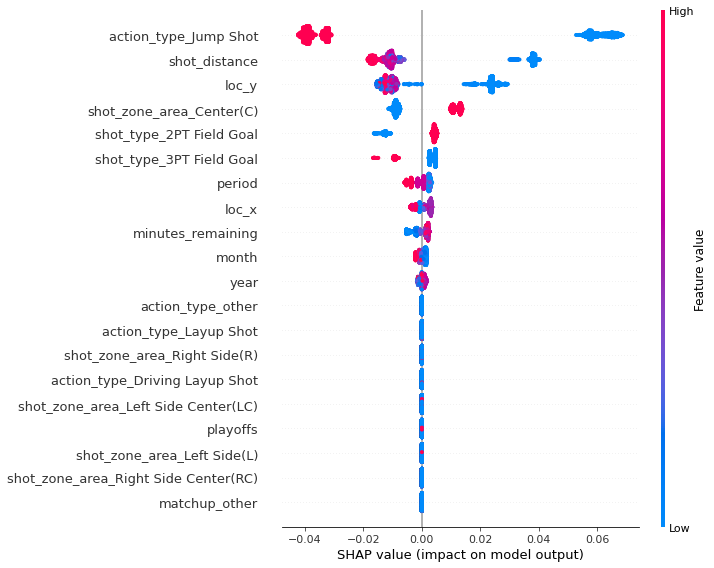

In [465]:
import shap  # package used to calculate Shap values
# For speed, we will calculate shap values on smaller subset of the validation data
data_for_prediction = X_test.copy()

explainer = shap.TreeExplainer(my_model)
shap_values = explainer.shap_values(data_for_prediction)
shap.summary_plot(shap_values[1], data_for_prediction)

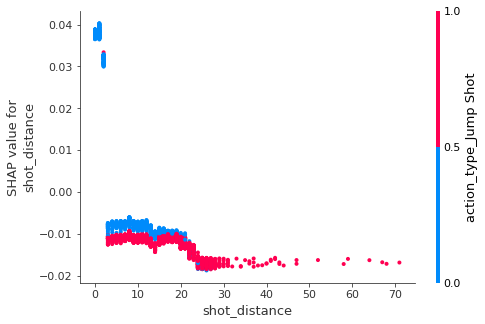

In [471]:
shap.dependence_plot("shot_distance",
                     shap_values[1],
                     features=X_test)
                     #interaction_index=None) 

### Force plot

In [460]:
data_for_prediction = X_test.sample(n=1000)

# Calculate Shap values
shap_values = explainer.shap_values(data_for_prediction)

shap.initjs()
shap.force_plot(explainer.expected_value[1],
                shap_values[1],
                data_for_prediction)

### Force plot pra observacoes especificas

In [500]:
y_train.mean()

0.44709831201050737

#### exemplo predict 0

In [493]:
row_to_show = 30182

data_for_prediction = X_test.loc[row_to_show]  # use 1 row of data here. Could use multiple rows if desired
data_for_prediction_array = data_for_prediction.values.reshape(1, -1)

my_model.predict_proba(data_for_prediction_array)

array([[0.65027474, 0.34972526]])

In [494]:
# Create object that can calculate shap values
explainer = shap.TreeExplainer(my_model)

# Calculate Shap values
shap_values = explainer.shap_values(data_for_prediction)

shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], data_for_prediction)

#### exemplo predict 1

In [495]:
row_to_show = 6795

data_for_prediction = X_test.loc[row_to_show]  # use 1 row of data here. Could use multiple rows if desired
data_for_prediction_array = data_for_prediction.values.reshape(1, -1)

my_model.predict_proba(data_for_prediction_array)


array([[0.4010529, 0.5989471]])

In [496]:

# Create object that can calculate shap values
explainer = shap.TreeExplainer(my_model)

# Calculate Shap values
shap_values = explainer.shap_values(data_for_prediction)

shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], data_for_prediction)